# Cenaero

In [1]:
import numpy as np

In [2]:
# Constants

NUM_SEQUENCES = 121
DATA_PATH = '../data/38Q31TzlO-{}/npz_data/data.npz'
PARAMS_PATH = '../data/38Q31TzlO-{}/Minamo_Parameters-Wall2D.txt'
RANDOM_SEED = 20210831

In [3]:
# Data loading and parsing methods

def load_data(simulation_ids, flatten_sequences=False):
    
    inputs, targets = [], []
    
    for simulation_id in simulation_ids:

        data = np.load(DATA_PATH.format(simulation_id))

        # Unused
        # T_top = data['T_top']
        # x = data['x']
        # y = data['y']
        # temperatures = data['temperatures']
        
        # Parse parameters
        with open(PARAMS_PATH.format(simulation_id)) as params_file:
            lines = params_file.read().splitlines()
            power = float(lines[0].split(' = ')[1])
            break_time = float(lines[1].split(' = ')[1])

        # Input data
        time = data['time']
        delta = time.copy()
        delta[1:] = time[1:] - time[:-1]
        laser_position = data['laser_position_x']
        laser_power = data['laser_power']
        power = np.full(laser_power.shape, power)
        break_time = np.full(laser_power.shape, break_time)
        input = np.stack([time, delta, laser_position, laser_power, power, break_time], axis=1)

        # Target data
        target = np.stack([data['T{}'.format(i + 1)] for i in range(6)], axis=1)

        inputs.append(input)
        targets.append(target)
    
    if flatten_sequences:
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
    else:
        max_len = max(input.shape[0] for input in inputs)
        
        for i, input in enumerate(inputs):
            inputs[i] = np.pad(input, [(0, max_len - input.shape[0]), (0, 0)])
        for i, target in enumerate(targets):
            targets[i] = np.pad(target, [(0, max_len - target.shape[0]), (0, 0)])
        
        inputs = np.stack(inputs, axis=1)
        targets = np.stack(targets, axis=1)
    
    return inputs.astype(np.float32), targets.astype(np.float32)

In [4]:
# Preview of the data

inputs, targets = load_data(range(1, 8 + 1), flatten_sequences=False)

print('inputs:', inputs.shape)
print('targets:', targets.shape)

inputs: (1384, 8, 6)
targets: (1384, 8, 6)


## Train, test and validation split

In [5]:
np.random.seed(RANDOM_SEED)
permutation = np.random.permutation(np.arange(1, NUM_SEQUENCES + 1))
first_split = int(0.7 * NUM_SEQUENCES)
second_split = int(0.85 * NUM_SEQUENCES)
train_sequence_ids = permutation[:first_split]
valid_sequence_ids = permutation[first_split:second_split]
test_sequence_ids = permutation[second_split:]

In [6]:
train_inputs, train_targets = load_data(train_sequence_ids, flatten_sequences=True)
valid_inputs, valid_targets = load_data(valid_sequence_ids, flatten_sequences=True)
test_inputs, test_targets = load_data(test_sequence_ids, flatten_sequences=True)

## Machine learning models

In [7]:
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8, 6)

os.makedirs('../outputs', exist_ok=True)

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1)

In [9]:
rf.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=20210831)

In [10]:
valid_preds = rf.predict(valid_inputs)

In [11]:
mse_loss = ((valid_preds - valid_targets) ** 2).sum() / valid_preds.shape[0]
print(mse_loss)

9271.277570311426


### Validation sample sequence

In [12]:
sample_valid_id = np.random.choice(valid_sequence_ids, size=(1,))
sample_valid_inputs, sample_valid_targets = load_data(sample_valid_id, flatten_sequences=True)

sample_valid_preds = rf.predict(sample_valid_inputs)

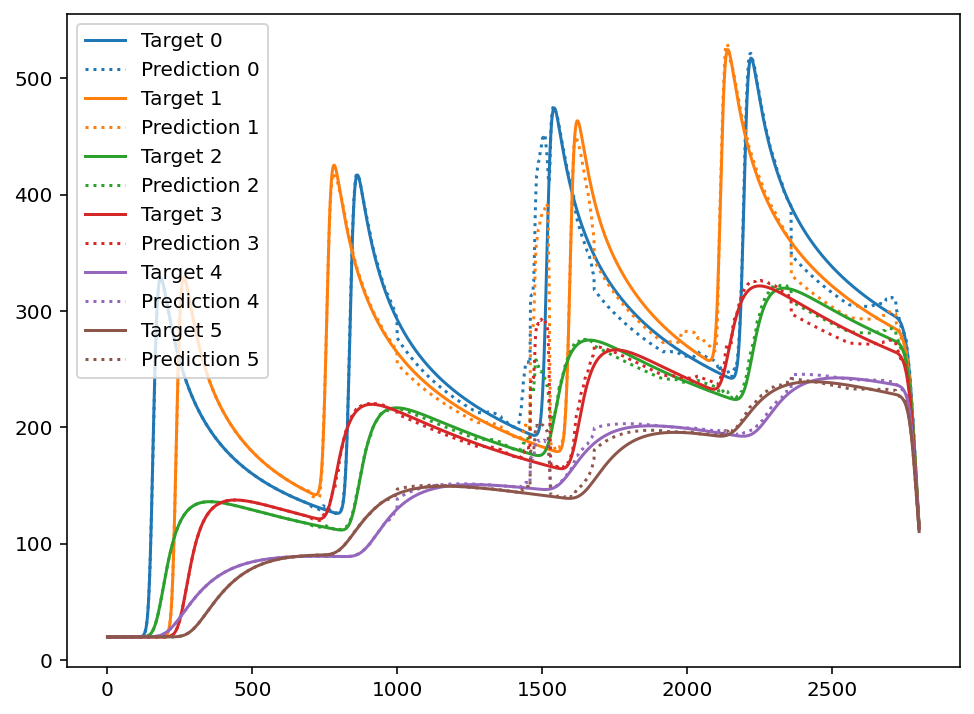

In [13]:
for i in range(6):
    plt.plot(sample_valid_targets[:, i], color='C{}'.format(i), label='Target {}'.format(i))
    plt.plot(sample_valid_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction {}'.format(i))
    plt.legend()

### Training sample sequence

In [14]:
sample_train_id = np.random.choice(train_sequence_ids, size=(1,))
sample_train_inputs, sample_train_targets = load_data(sample_train_id, flatten_sequences=True)

sample_train_preds = rf.predict(sample_train_inputs)

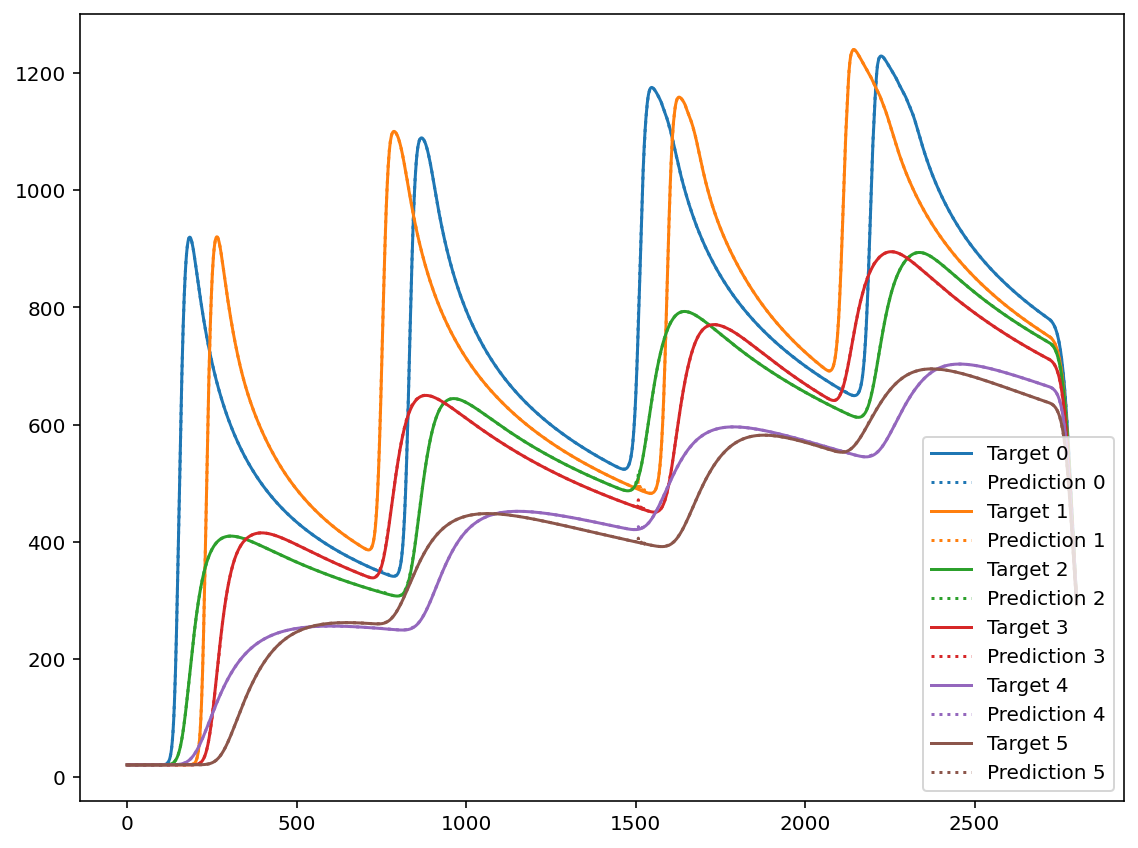

In [15]:
for i in range(6):
    plt.plot(sample_train_targets[:, i], color='C{}'.format(i), label='Target {}'.format(i))
    plt.plot(sample_train_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction {}'.format(i))
    plt.legend()
plt.tight_layout()
plt.show()

## Deep learning models

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_hidden = num_hidden
        
        hidden_layers = []
        for _ in range(num_hidden - 1):
            hidden_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            hidden_layers.append(nn.ReLU())
        
        self.sequential = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            *hidden_layers,
            nn.Linear(self.hidden_size, self.output_size)
        )
    
    def forward(self, x):
        return self.sequential(x)

### Convert data array to tensor

In [18]:
train_inputs = torch.from_numpy(train_inputs)
train_targets = torch.from_numpy(train_targets)
valid_inputs = torch.from_numpy(valid_inputs)
valid_targets = torch.from_numpy(valid_targets)
test_inputs = torch.from_numpy(test_inputs)
test_targets = torch.from_numpy(test_targets)

In [19]:
num_train = train_inputs.size(0)
num_valid = valid_inputs.size(0)
num_test = test_inputs.size(0)

### Hyperparameters and instantiation

In [20]:
BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_HIDDEN = 2
LEARNING_RATE = 1e-3
NUM_EPOCH_CONVERGENCE = 5

In [21]:
mlp = MLP(
    input_size=train_inputs.size(1),
    hidden_size=HIDDEN_SIZE,
    output_size=train_targets.size(1),
    num_hidden=NUM_HIDDEN)
opt = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

model_name = 'mlp-' + '-'.join(str(HIDDEN_SIZE) for _ in range(NUM_HIDDEN))
print(mlp)

MLP(
  (sequential): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)


### Training

In [22]:
from copy import deepcopy

lowest_loss, num_epoch_no_improvement = float('inf'), 0
best_weights = deepcopy(mlp.state_dict())
train_losses, valid_losses = [], []

epoch = 0
while num_epoch_no_improvement <= NUM_EPOCH_CONVERGENCE:
    
    # Training
    permutation = torch.randperm(num_train)
    train_loss = 0.0

    for i in range(0, num_train, BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_inputs = train_inputs[indices, :]
        batch_targets = train_targets[indices, :]
        
        batch_preds = mlp(batch_inputs)
        loss = F.mse_loss(batch_preds, batch_targets)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        train_loss += loss.item()

    train_loss /= int(num_train / BATCH_SIZE)
    train_losses.append(train_loss)
    
    epoch += 1
    
    # validuation
    with torch.no_grad():
        valid_preds = mlp(valid_inputs)
        valid_loss = F.mse_loss(valid_preds, valid_targets).item()
    
    valid_losses.append(valid_loss)
    
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        num_epoch_no_improvement = 0
        best_weights = deepcopy(mlp.state_dict())
    else:
        num_epoch_no_improvement += 1
    
    print('Epoch {:03d}: train: {:.4f}, valid: {:.4f}'.format(epoch, train_loss, valid_loss))

mlp.load_state_dict(best_weights)

Epoch 001: train: 14550.5108, valid: 9668.5967
Epoch 002: train: 6409.9631, valid: 4336.3672
Epoch 003: train: 3475.8269, valid: 2723.7954
Epoch 004: train: 1976.1675, valid: 1369.1105
Epoch 005: train: 997.2018, valid: 944.3919
Epoch 006: train: 578.4450, valid: 389.7312
Epoch 007: train: 380.2946, valid: 353.1946
Epoch 008: train: 282.9752, valid: 251.8038
Epoch 009: train: 225.3682, valid: 244.8221
Epoch 010: train: 181.8101, valid: 141.7556
Epoch 011: train: 164.4942, valid: 118.4375
Epoch 012: train: 146.0682, valid: 84.7314
Epoch 013: train: 126.8675, valid: 185.0236
Epoch 014: train: 121.9182, valid: 322.9625
Epoch 015: train: 110.9733, valid: 136.8090
Epoch 016: train: 100.4656, valid: 55.0699
Epoch 017: train: 97.2287, valid: 90.0842
Epoch 018: train: 90.2184, valid: 302.1943
Epoch 019: train: 86.9251, valid: 67.3534
Epoch 020: train: 80.1746, valid: 94.0610
Epoch 021: train: 77.1953, valid: 63.3213
Epoch 022: train: 76.2553, valid: 60.3637


<All keys matched successfully>

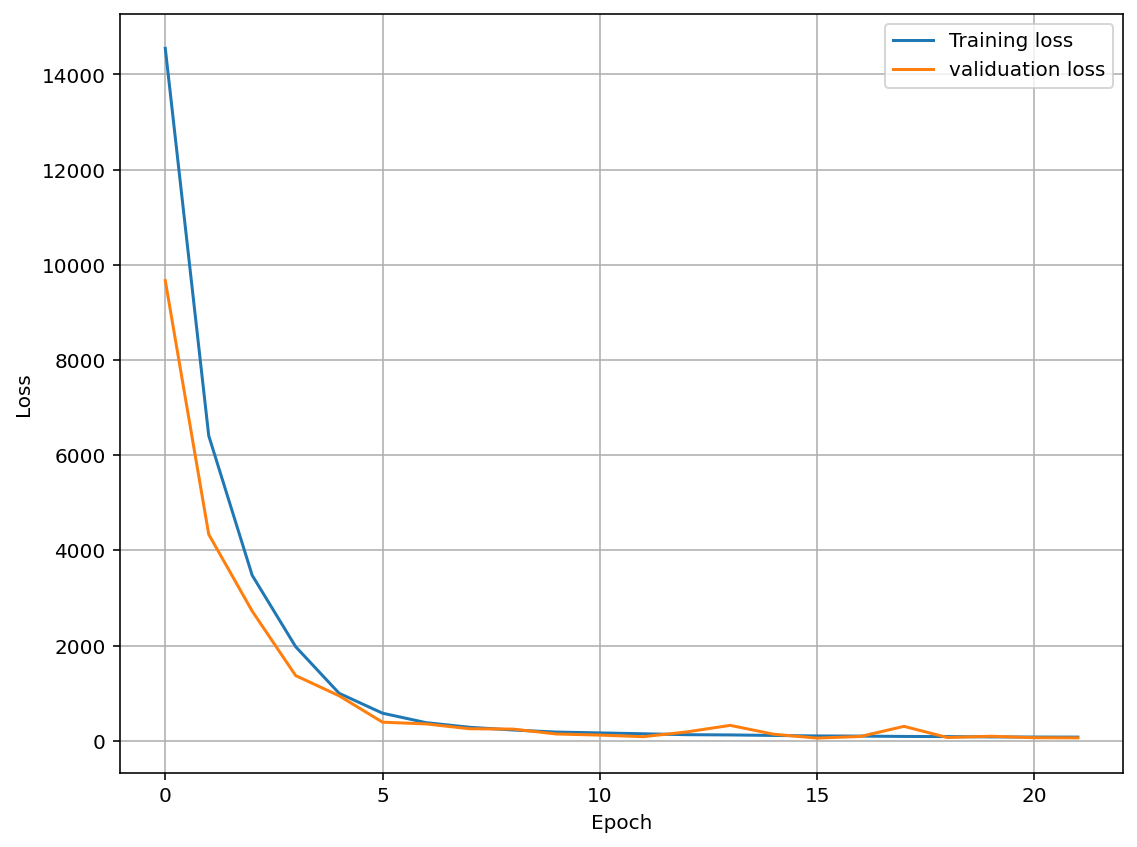

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_losses, label='Training loss')
ax.plot(valid_losses, label='validuation loss')
ax.grid()
ax.legend()
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
plt.tight_layout()
fig.savefig('../outputs/{}.pdf'.format(model_name), transparent=True)

### Validation sample sequence

In [24]:
sample_valid_id = np.random.choice(valid_sequence_ids, size=(1,))
sample_valid_inputs, sample_valid_targets = load_data(sample_valid_id, flatten_sequences=True)

sample_valid_inputs = torch.from_numpy(sample_valid_inputs)

with torch.no_grad():
    sample_valid_preds = mlp(sample_valid_inputs)

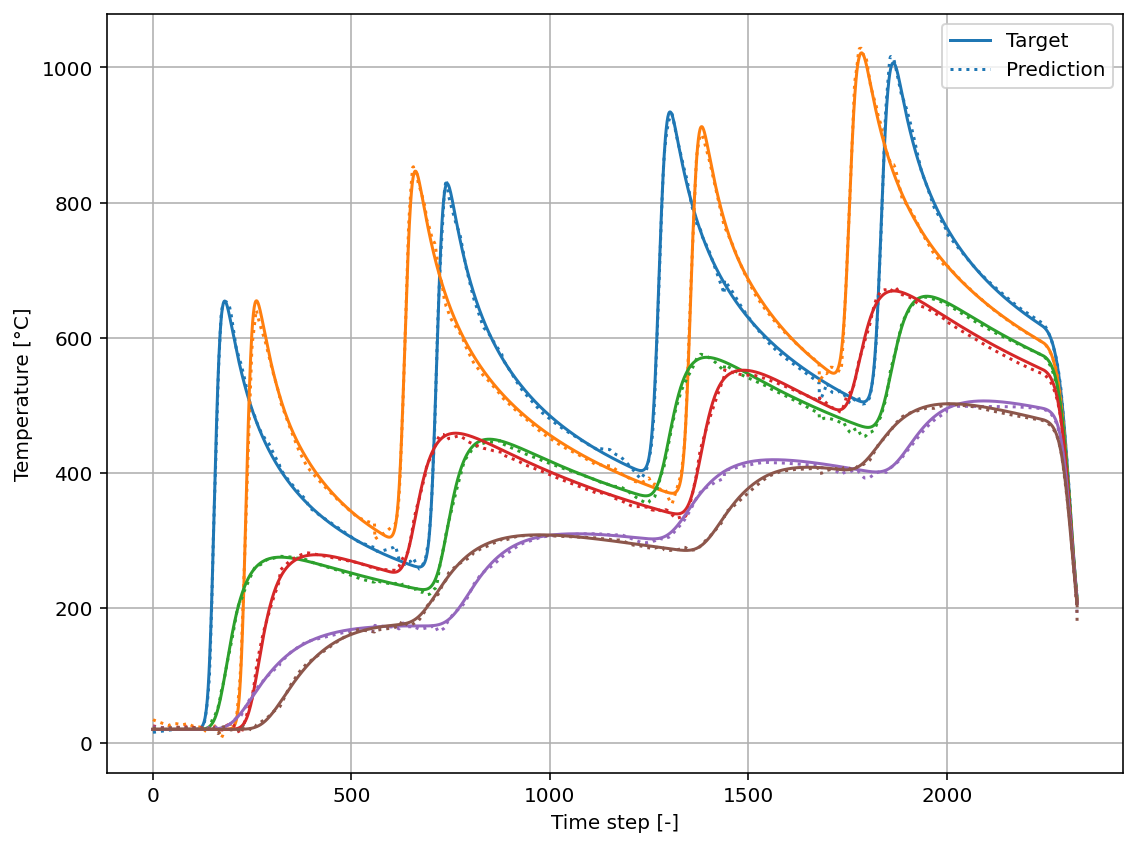

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
for i in range(6):
    ax.plot(sample_valid_targets[:, i], color='C{}'.format(i), label='Target')
    ax.plot(sample_valid_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
ax.set_xlabel('Time step [-]')
ax.set_ylabel('Temperature [°C]')
plt.tight_layout()
plt.savefig('../outputs/{}-valid.pdf'.format(model_name))

### Training sample sequence

In [26]:
sample_train_id = np.random.choice(train_sequence_ids, size=(1,))
sample_train_inputs, sample_train_targets = load_data(sample_train_id, flatten_sequences=True)

sample_train_inputs = torch.from_numpy(sample_train_inputs)

with torch.no_grad():
    sample_train_preds = mlp(sample_train_inputs)

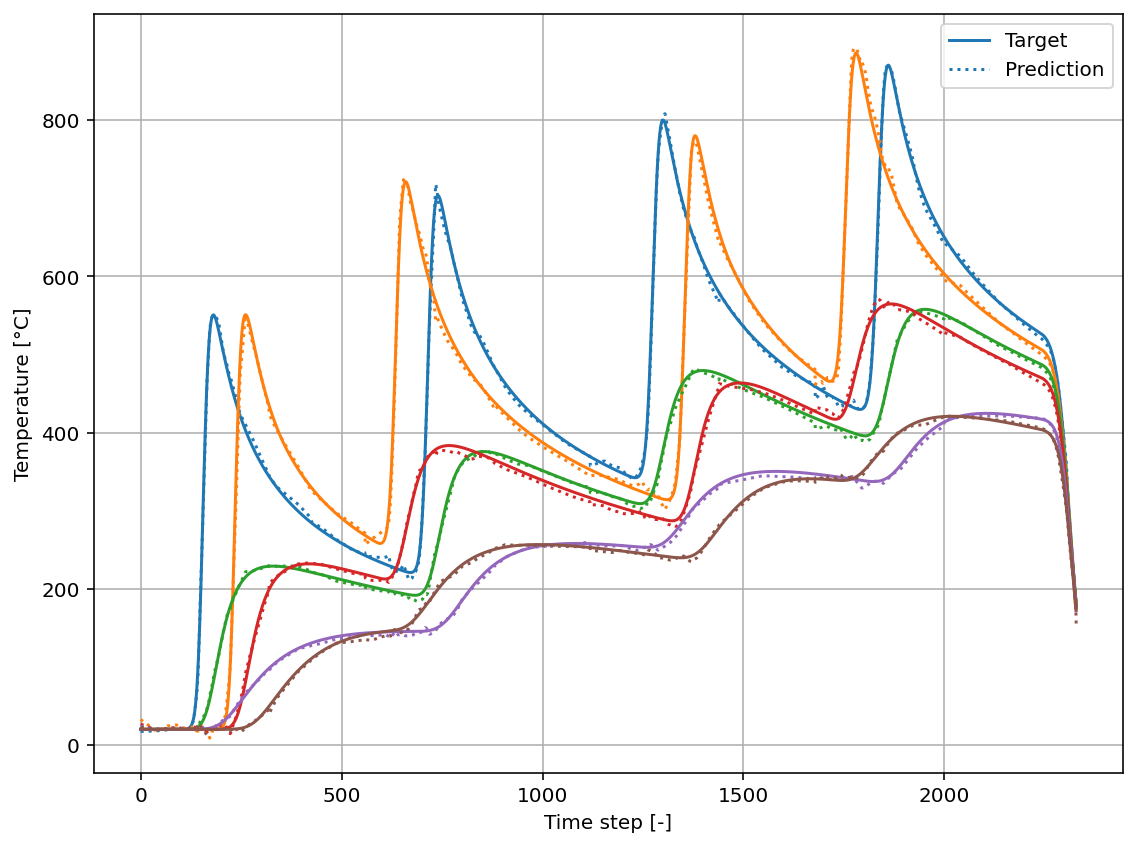

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid()
for i in range(6):
    ax.plot(sample_train_targets[:, i], color='C{}'.format(i), label='Target')
    ax.plot(sample_train_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
ax.legend(handles, labels)
ax.set_xlabel('Time step [-]')
ax.set_ylabel('Temperature [°C]')
plt.tight_layout()
plt.savefig('../outputs/{}-train.pdf'.format(model_name))

### Evaluation on the test set

In [28]:
with torch.no_grad():
    train_preds = mlp(train_inputs)
    train_loss = F.mse_loss(train_preds, train_targets).item()
with torch.no_grad():
    valid_preds = mlp(valid_inputs)
    valid_loss = F.mse_loss(valid_preds, valid_targets).item()
with torch.no_grad():
    test_preds = mlp(test_inputs)
    test_loss = F.mse_loss(test_preds, test_targets).item()

print('Train set: {:.4f}'.format(train_loss))
print('Validation set: {:.4f}'.format(valid_loss))
print('Test set: {:.4f}'.format(test_loss))

Train set: 46.2202
Validation set: 55.0699
Test set: 66.3324
